### Solve Gearbox Ratios

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.transforms import Affine2D
import time
from matplotlib.offsetbox import AnchoredText 
import mplcursors 
import os
import json
from gearbox import Gearbox

from tqdm import tqdm

In [3]:
config = {
  "MODULE": 0.8e-3,
  "MC": 0.8467e-3,
  "MU": 0.25,
  "ALPHA": 20,
  "XS": 0.476,
  "XP1": 0.762,
  "XP2": 0.536,
  "XR1": 2,
  "XR2": 1.21,
  "XS_RANGE": [-0.5, 0.5, 0.125],
  "XP1_RANGE": [-1, 1, 0.125],
  "XP2_RANGE": [-0.5, 0.5, 0.125],
  "XR2_RANGE": [-1.5, 1.5, 0.125],
  "N_PLANETS": 3,
  "SUN_LIMITS": [12, 30],
  "P1_LIMITS": [39, 51],
  "P2_LIMITS": [32, 44],
  "R2_LIMITS": [81, 97],
  "STEPS": [2, 2, 2, 2],
  "MIN_RATIO_THRESHOLD": 90,
  "MIN_FORWARD_THRESHOLD": 0.30,
  "MIN_BACKWARD_THRESHOLD": 0.30
}

In [4]:
MODULE = config["MODULE"]
MU = config["MU"]
MC = config.get("MC", MODULE)
ALPHA = np.radians(config.get("ALPHA", 20))
XR1 = config.get("XR1", 0.0)
N_PLANETS = config["N_PLANETS"]
SUN_LIMITS = tuple(config["SUN_LIMITS"])
P1_LIMITS  = tuple(config["P1_LIMITS"])
P2_LIMITS  = tuple(config["P2_LIMITS"])
R2_LIMITS  = tuple(config["R2_LIMITS"])
STEPS = tuple(config["STEPS"])
MIN_RATIO_THRESHOLD = config["MIN_RATIO_THRESHOLD"]
MIN_FORWARD_THRESHOLD = config["MIN_FORWARD_THRESHOLD"]
MIN_BACKWARD_THRESHOLD = config["MIN_BACKWARD_THRESHOLD"]

SLICE_GEAR_RATIO = True 
TARGET_GEAR_RATIO = 100
RATIO_TOLERANCE = 10
DISPLAY_BEST_GEARBOX = False
DISPLAY_ITERATIONS_PLOT = True
RUN_SAMPLE_TRIAL = False
MAX_CANDIDATES = 400

In [7]:
def generate_options(lower: int, upper: int, step: int = 1):
    return list(range(lower, upper + 1, step))

def generate_range_options(range_vals):
    low, high, step = range_vals
    opts = []
    current = low
    while current <= high + 1e-9:
        opts.append(round(current, 5))
        current += step
    return opts

def generate_all_options(sun_limits: tuple, p1_limits: tuple, p2_limits: tuple, r2_limits: tuple, 
                         steps: tuple = (1,1,1,1)):
    step_sun, step_p1, step_p2, step_r2 = steps
    return {
        "sun": generate_options(sun_limits[0], sun_limits[1], step_sun),
        "p1": generate_options(p1_limits[0], p1_limits[1], step_p1),
        "p2": generate_options(p2_limits[0], p2_limits[1], step_p2),
        "r2": generate_options(r2_limits[0], r2_limits[1], step_r2)
    }

In [8]:
options = generate_all_options(SUN_LIMITS, P1_LIMITS, P2_LIMITS, R2_LIMITS, STEPS)
sun_options = options["sun"]
p1_options  = options["p1"]
p2_options  = options["p2"]
r2_options  = options["r2"]
xs_options = generate_range_options(config["XS_RANGE"])
xp1_options = generate_range_options(config["XP1_RANGE"])
xp2_options = generate_range_options(config["XP2_RANGE"])
xr2_options = generate_range_options(config["XR2_RANGE"])

In [21]:
def view_vector(input_vector, subsample, title, y_lims=None):
    fig, ax = plt.subplots()
    to_plot = input_vector[::subsample]
    xs = np.arange(len(to_plot))
    ax.scatter(xs, to_plot)
    ax.set_title(title)
    if y_lims:
        ax.set_ylim(y_lims)
    plt.show()

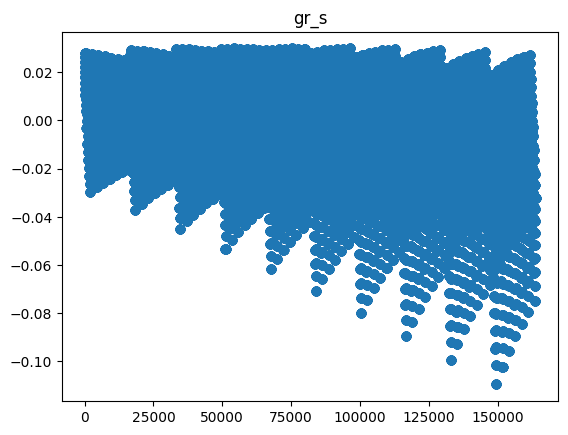

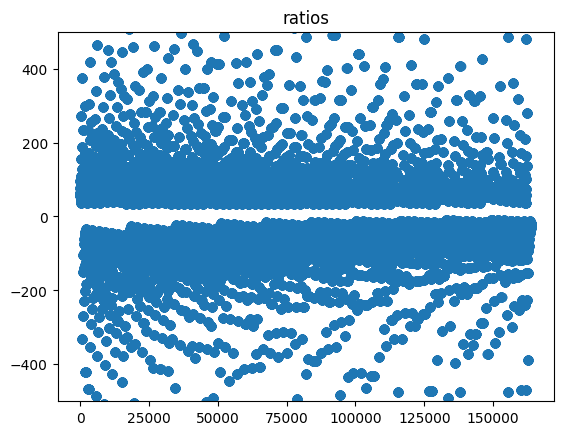

Of 151814250 total inputs, there are 5060475 valid combinations
Efficiency shapes: (5060475,), (5060475,)
Average Forward Efficiency: 0.2417 +/- 0.1843
Average Backward Efficiency: 0.0493 +/- 0.1364


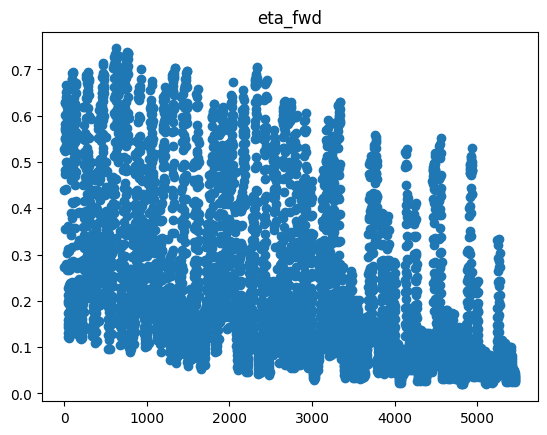

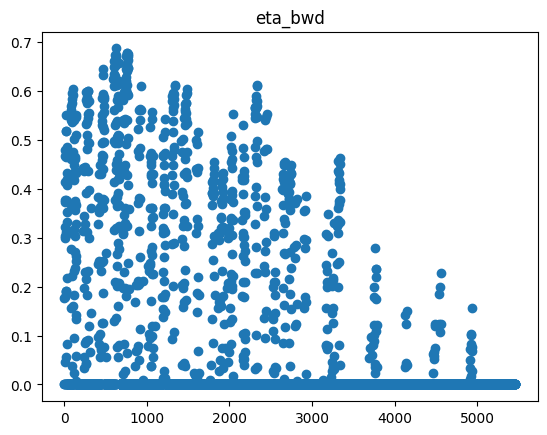

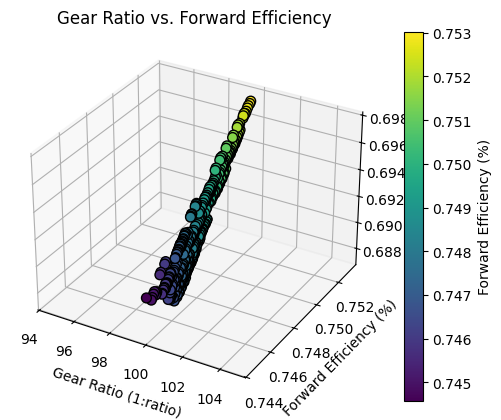

In [ ]:
z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2 = np.meshgrid(
    sun_options, p1_options, p2_options, r2_options, xs_options, xp1_options, xp2_options, xr2_options, indexing='ij'
)

total_combinations = z_s.size

# flatten everything
z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2 = z_s.flatten(), z_p1.flatten(), z_p2.flatten(), z_r2.flatten(), xs.flatten(), xp1.flatten(), xp2.flatten(), xr2.flatten()

z_r1 = z_s + 2 * z_p1

I1 = z_r1 / z_s
I2 = (z_r1 * z_p2) / (z_p1 * z_r2)
gr_s = (1 - I2) / (1 + I1)
ratios = 1 / gr_s

# plot some vals
ss = 927 # don't use round numbers (aliasing)
# view_vector(I1, ss, "I1")
# view_vector(I2, ss, "I2")
view_vector(gr_s, ss, "gr_s")
view_vector(ratios, ss, "ratios", y_lims=(-500, 500))
# view_vector(z_s, ss, "z_s")
# view_vector(z_p1, ss, "z_p1")
# view_vector(z_p2, ss, "z_p2")
# view_vector(z_r2, ss, "z_r2")
# view_vector(xs, ss, "xs")
# view_vector(xp1, ss, "xp1")
# view_vector(xp2, ss, "xp2")
# view_vector(xr2, ss, "xr2")
# view_vector(z_r1, ss, "z_r1")

# only keep valid combinations (ratios w.in tolerance)
valid_combinations = np.logical_and(gr_s > 0, np.abs(TARGET_GEAR_RATIO - ratios) <= RATIO_TOLERANCE)

z_r1 = z_r1[valid_combinations]
z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2 = z_s[valid_combinations], z_p1[valid_combinations], z_p2[valid_combinations], z_r2[valid_combinations], xs[valid_combinations], xp1[valid_combinations], xp2[valid_combinations], xr2[valid_combinations]
I1, I2, gr_s, ratios = I1[valid_combinations], I2[valid_combinations], gr_s[valid_combinations], ratios[valid_combinations]

assert z_s.shape == z_p1.shape == z_r1.shape == z_p2.shape == z_r2.shape == xs.shape == xp1.shape == xp2.shape == xr2.shape == ratios.shape

print(f'Of {total_combinations} total inputs, there are {len(z_s)} valid combinations')

ra = (z_s * MODULE + z_p1 * MODULE) / 2.0

# Basic circle diameters
db_a1 = MODULE * z_s * np.cos(ALPHA)
db_a2 = MODULE * z_p1 * np.cos(ALPHA)
db_b1 = MODULE * z_p1 * np.cos(ALPHA)
db_b2 = MODULE * z_r1 * np.cos(ALPHA)
db_c1 = MC * z_p2 * np.cos(ALPHA)
db_c2 = MC * z_r2 * np.cos(ALPHA)

# Working pressure angles (modified formula)
alpha_wa = np.arccos(MODULE * (z_s + z_p1) * np.cos(ALPHA) / (2 * ra))
alpha_wb = np.arccos(MODULE * (-z_p1 + z_r1) * np.cos(ALPHA) / (2 * ra)) # why is this constant??
val = MC * (-z_p2 + z_r2) * np.cos(ALPHA) / (2 * ra)
alpha_wc = np.arccos(np.clip(val, -1, 1))
# Center distance modification coefficient
ya = ((z_s + z_p1) / 2.0) * ((np.cos(ALPHA) / np.cos(alpha_wa)) - 1)
# Tip circle diameters
das  = MODULE * z_s + 2 * MODULE * (1 + ya - xp1)
dap1 = MODULE * z_p1 + 2 * MODULE * (1 + np.minimum(ya - xs, xp1))
dar1 = MODULE * z_r1 - 2 * MODULE * (1 - XR1)
dap2 = MC * z_p2 + 2 * MC * (1 + xp2)
dar2 = MC * z_r2 - 2 * MC * (1 - xr2)
# Tip pressure angles
alpha_aa1 = np.arccos(db_a1 / das)
alpha_aa2 = np.arccos(db_a2 / dap1)
alpha_ab1 = np.arccos(db_b1 / dap1)
alpha_ab2 = np.arccos(db_b2 / dar1)
alpha_ac1 = np.arccos(db_c1 / dap2)
val2 = db_c2 / dar2
alpha_ac2 = np.arccos(np.clip(val2, -1, 1))
# Approach and recess contact ratios
ea1 = (z_p1 / (2 * np.pi)) * (np.tan(alpha_aa2) - np.tan(alpha_wa))
ea2 = (z_s / (2 * np.pi)) * (np.tan(alpha_aa1) - np.tan(alpha_wa))
eb1 = -(z_r1 / (2 * np.pi)) * (np.tan(alpha_ab2) - np.tan(alpha_wb))
eb2 = (z_p1 / (2 * np.pi)) * (np.tan(alpha_ab1) - np.tan(alpha_wb))
ec1 = -(z_r2 / (2 * np.pi)) * (np.tan(alpha_ac2) - np.tan(alpha_wc))
ec2 = (z_p2 / (2 * np.pi)) * (np.tan(alpha_ac1) - np.tan(alpha_wc))
ea = ea1**2 + ea2**2 - ea1 - ea2 + 1
eb = eb1**2 + eb2**2 - eb1 - eb2 + 1
ec = ec1**2 + ec2**2 - ec1 - ec2 + 1
# Basic driving efficiencies
Ea_val = 1 - MU* np.pi * (1 / z_s + 1 / z_p1) * ea
Eb_val = 1 - MU* np.pi * (1 / z_p1 - 1 / z_r1) * eb
Ec_val = 1 - MU* np.pi * (1 / z_p2 - 1 / z_r2) * ec
# Forward driving efficiency 
eta_fwd = (1 + Ea_val * Eb_val * I1) * (1 - I2) / ((1 + I1) * (1 - Eb_val * Ec_val * I2))
# Backward driving efficiency
def eta_bwd1(I1, I2, Ea_val, Eb_val, Ec_val):
    return (1 + I1) * Ea_val * (Eb_val * Ec_val - I2) / (Ec_val * (Ea_val * Eb_val + I1) * (1 - I2))
def eta_bwd2(I1, I2, Ea_val, Eb_val, Ec_val):
    return (1 + I1)*Ea_val*(1-Eb_val*Ec_val*I2)/((Ea_val+Eb_val*I1)*(1-I2))
eta_bwd = np.where(I2 > 1, eta_bwd2(I1, I2, Ea_val, Eb_val, Ec_val), eta_bwd1(I1, I2, Ea_val, Eb_val, Ec_val))
# eta_bwd = (1 + I1) * Ea_val * (Eb_val * Ec_val - I2) / (Ec_val * (Ea_val * Eb_val + I1) * (1 - I2))

# filter high eta_bwd
eta_bwd = np.where(eta_bwd > 1, 0, eta_bwd)
eta_bwd = np.where(eta_bwd < 0, 0, eta_bwd)

# Average and std for eta
avg_fwd = np.mean(eta_fwd)
std_fwd = np.std(eta_fwd)
avg_bwd = np.mean(eta_bwd)
std_bwd = np.std(eta_bwd)
print(f'Efficiency shapes: {eta_fwd.shape}, {eta_bwd.shape}')
print(f"Average Forward Efficiency: {avg_fwd:.4f} +/- {std_fwd:.4f}")
print(f"Average Backward Efficiency: {avg_bwd:.4f} +/- {std_bwd:.4f}")

view_vector(eta_fwd, ss, "eta_fwd")
view_vector(eta_bwd, ss, "eta_bwd")

composite_score = ratios * eta_fwd * eta_bwd

# create a list of the n (Max_Candidates) best scores
# sort all vectors by composite score
sorted_indices = np.argsort(composite_score)[::-1]
best_indices = sorted_indices[:MAX_CANDIDATES]

# make 'best' versions of all the arrays
best_z_s = z_s[best_indices]
best_z_p1 = z_p1[best_indices]
best_z_r1 = z_r1[best_indices]
best_z_p2 = z_p2[best_indices]
best_z_r2 = z_r2[best_indices]
best_xs = xs[best_indices]
best_xp1 = xp1[best_indices]
best_xp2 = xp2[best_indices]
best_xr2 = xr2[best_indices]
best_ratios = ratios[best_indices]
best_eta_fwd = eta_fwd[best_indices]
best_eta_bwd = eta_bwd[best_indices]
best_composite_score = composite_score[best_indices]


# plot: Gear ratio, forward efficiency, backward efficiency (color forward efficiency)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(best_ratios, best_eta_fwd, best_eta_bwd, c=best_eta_fwd, cmap='viridis', edgecolor='k', alpha=1, s=50)
ax.set_xlabel("Gear Ratio (1:ratio)")
ax.set_ylabel("Forward Efficiency (%)")
ax.set_zlabel("Backward Efficiency (%)")
ax.set_title("Gear Ratio vs. Forward Efficiency")
fig.colorbar(sc, label="Forward Efficiency (%)")
plt.show()